## In this notebook, I give a simple example of an inverse problem which necessitates regularization. 

### Consider for instance $$I_{observed} = K_\sigma \star I + n$$ where $K_\sigma$ is a gaussian blur and $n$ is a gaussian iid noise. A naive idea consists in inverting $K_\sigma$ in Fourier space. It works when there is no noise, but completely fails in the presence of noise.

In [9]:
from __future__ import division
import numpy as np
import scipy as sp
%matplotlib inline
import scipy.fftpack as ft
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(633, 950, 3)
128.55839157104492 50.33679038212257 0.0
(512, 512)


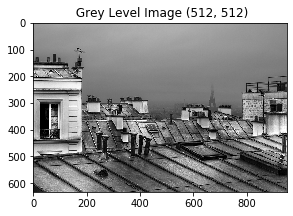

In [10]:
# load an image
import imageio as imio
colored_image = imio.imread('toits.jpg')
print(colored_image.shape)
n = colored_image.shape[0]-1
n = 512
image = np.sum(colored_image*[0.21, 0.72 ,0.07],axis=-1)[:n,100:100+n]

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.gray()
#cropped = image[n:n+64,n:n + 64]
plt.title(" Grey Level Image " + str(np.shape(image)))
cropped = image
plt.imshow(colored_image)
print(np.mean(cropped),np.std(cropped),(np.min(cropped)))
print(image.shape)
image0 = np.copy(image)

## Remark: Noise in Fourier is also a noise. You can guess that the distribution of the energy of the noise in Fourier is similar to its distribution in space.

noise pixels 262285.18741338124
noise fourier 262285.1874133812


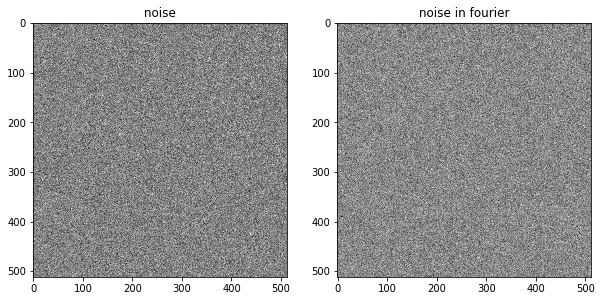

In [11]:
sigma = 1.0
noise = sigma*np.random.randn(image.shape[0],image.shape[1])
noise_fourier = fft2(noise,norm = "ortho")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.gray()
plt.imshow(noise)
plt.title(" noise ")
plt.subplot(1,2,2)
plt.imshow(real(noise_fourier))
plt.title(" noise in fourier ")
print("noise pixels",np.sum(noise**2))
print("noise fourier",np.sum(np.abs(noise_fourier)**2))

-0.0


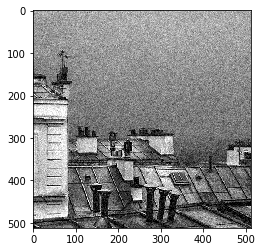

In [12]:
## Add some noise to the image
def clamp(x):
    temp =  255*(x>255) + x * (x<255) 
    return temp * (x>0)

sigma = 20.0
def GaussianNoise(image,sigma):
    return image + sigma*np.random.randn(image.shape[0],image.shape[1])

def SaltNoise(image,sigma):
    return clamp(image + sigma*(np.random.randn(image.shape[0],image.shape[1])>0))

noisy_image  = clamp(image + sigma*np.random.randn(image.shape[0],image.shape[1]))
print(np.min(noisy_image))
plt.imshow(noisy_image)

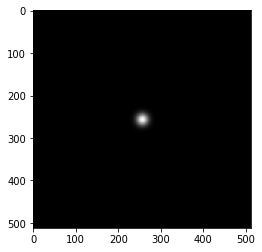

In [13]:
### Construct a gaussian filter.
def construct_gaussian_filter(n,sigma_filter):
    t = np.concatenate((np.arange(0,n/2+1), np.arange(-n/2,-1)))
    [Y,X] = np.meshgrid(t,t)
    h = np.exp(-(X**2+Y**2)/(2.0*sigma_filter**2) )
    h = h/np.sum(h)
    return h
sigma = 10
n = 512
h = construct_gaussian_filter(n,sigma)
imshow(ft.fftshift(h))

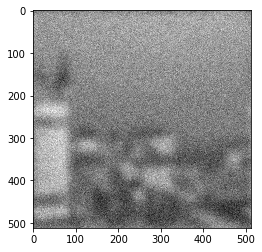

In [14]:
## In Fourier space, convolution is product so 
def myConvPlusNoise(image,sigma_filtre = 0.0,sigma_noise = 0.0):
    w = construct_gaussian_filter(image.shape[0],sigma_filtre)
    temp = real(ifft2(fft2(w)*fft2(image)))
    result= GaussianNoise(temp,sigma_noise) 
    return result

observed_image = myConvPlusNoise(image,sigma_filtre = 10, sigma_noise = 20)
imshow(observed_image)

In [15]:
### simple inversion using fft
### assume that sigma_filter is known
def naive_deconvolution(image_observed,sigma_filter):
    w = construct_gaussian_filter(image_observed.shape[0],sigma_filter)
    deconv = real(ifft2(fft2(image_observed)/fft2(w))) 
    return deconv

Text(0.5, 1.0, ' data ')

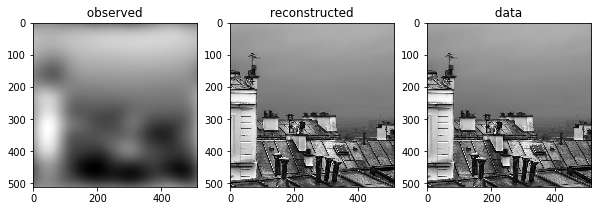

In [16]:
### First test: without noise.

sigma_filtre = 30.0
observed_image = myConvPlusNoise(image,sigma_filtre = sigma_filtre, sigma_noise = 0.0)
reconstructed = naive_deconvolution(observed_image,sigma_filtre)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.gray()
plt.imshow(observed_image)
plt.title(" observed ")
plt.subplot(1,3,2)
plt.imshow(reconstructed)
plt.title(" reconstructed ")
plt.subplot(1,3,3)
plt.imshow(image)
plt.title(" data ")

Text(0.5, 1.0, ' data ')

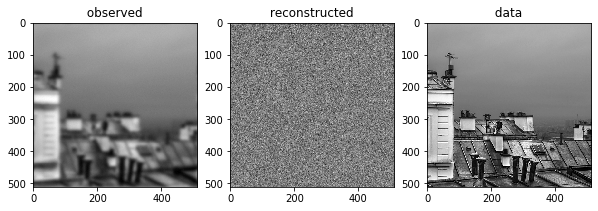

In [17]:
### Second test: with noise.

sigma_filtre = 5.0
observed_image = myConvPlusNoise(image,sigma_filtre = sigma_filtre, sigma_noise = 1)
reconstructed = naive_deconvolution(observed_image,sigma_filtre)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.gray()
plt.imshow(observed_image)
plt.title(" observed ")
plt.subplot(1,3,2)
plt.imshow(reconstructed)
plt.title(" reconstructed ")
plt.subplot(1,3,3)
plt.imshow(image)
plt.title(" data ")

### You can observe that, even with a small value of noise, the reconstruction seems to be just noise. Note that the bigger the gaussian width of the gaussian filter, the more sensitive to noise is this reconstruction scheme. The lecture explains why it is the case.